<div class="span5 alert alert-info">
<span style="color:black">
    
<h1> Part 2-  Recall Forecasting - ARIMA model </h1>

As a proof of concept, I did forecasting for overall recalls. We could do the same analyses for individual Manufacturers. 
    <span></div>


In [2]:
# importing the libraries required for this section

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_pickle('df_cleaned.pkl')
y = pd.DataFrame(df['MAKETXT'].resample('m').count())
y.head()

,MAKETXT
RCDATE,
1972-10-31,21
1972-11-30,0
1972-12-31,0
1973-01-31,0
1973-02-28,0


<div class="span5 alert alert-warning">
<span style="color:black">
    
Let's decompose the time series data in to 3 segments:

<ol>
<li> <b>Trend:</b> The overall direction that the data is travelling in (like upwards or downwards) </li><li> <b>Seasonality:</b> Cyclical patterns in the data </li>
    
<li> <b>Noise:</b> The random variation in the data <span></div> </li>
    
</ol>

<div class="span5 alert alert-warning">
<span style="color:black">

<h3> Decomposing time series data </h3>
    

   Time series data decomposition is a method to split data series into the components like a trend, seasonal, and irregular noise.
    
 <ul>
 <li> Trend component reflects the overall direction in data. It is mean value over time. </li>
    
    
<li>Seasonal component is variations that occur at specific regular intervals in data series (e.g., weekly, monthly). </li>
    
    
<li>Irregular (noise) component is residuals that is a remaining part after removing the above components.</li>
    
</ul>
       
<h4> The following two structures are considered for basic decomposition models: </h4>
    

Additive:  = Trend + Seasonal + Random

Multiplicative:  = Trend * Seasonal * Random
       
       
    
<h4> How to Choose Between Additive and Multiplicative Decompositions </h4>
       
       
The additive model is useful when the seasonal variation is relatively constant over time.
The multiplicative model is useful when the seasonal variation increases over time.
<span></div>

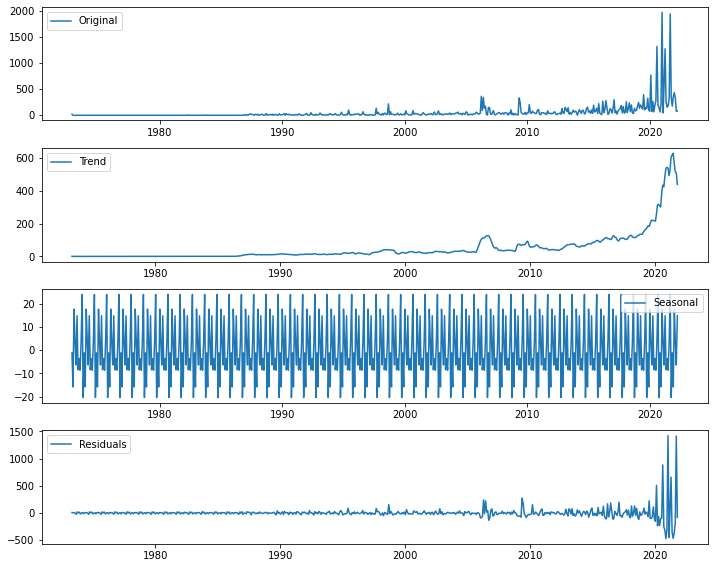

In [4]:
# import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose

# make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition2 = seasonal_decompose(y, model='additive')

# make three variables for trend, seasonal and residual components respectively 
# assign them the relevant features of decomposition 
trend = decomposition2.trend
seasonal = decomposition2.seasonal
residual = decomposition2.resid

# plot the original data, the trend, the seasonality, and the residuals
plt.figure(figsize=(10,8))
plt.subplot(411)
plt.plot(y, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

<div class="span5 alert alert-warning">
<span style="color:black">

<ul>
<li>There seems to be strong seasonality when we resample the data monthly. </li>
<li>There is also a strong trend after 2000s which is increasing sharply causing an exponensial increase in recall campaigns.</li>
<li>Even with the trend and seasonality is accounted, the sharp peak at 2021 is unusual, as evidenced by the residual plot. Therefore, 2021 is an outlier.</li>
</ul>
<span></div>

<div class="span5 alert alert-warning">
<span style="color:black">

<h4> Making the data stationary</h4>
    
<ul>
<li>Test the null hypothesis that the model is random walk with Augmented Dicky-Fuller Test.</li>
    
<li>Test the hypothesis that model is stationary with KPSS test.</li>
    
<li>Make the model stationary taking difference of the values.</li>
    </ul>
    <span></div>

<div class="span5 alert alert-warning">
<span style="color:black">

<h4> Dickey–Fuller test</h4>

In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive time series model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.
    
Unit Root: The presence of a unit root means the time series is non-stationary. Besides, the number of unit roots contained in the series corresponds to the number of differencing operations required to make the series stationary. 
    
<h4> Augmented Dickey–Fuller test</h4>
    
Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series.
    
    
<ul>
<li>In ARIMA time series forecasting, the first step is to determine the number of differencing required to make the series stationary. Since testing the stationarity of a time series is a frequently performed activity in autoregressive models, the ADF test along with KPSS test is something that you need to be fluent in when performing time series analysis. Another point to remember is the ADF test is fundamentally a statistical significance test. That means, there is a hypothesis testing involved with a null and alternate hypothesis and as a result a test statistic is computed and p-values get reported. It is from the test statistic and the p-value, you can make an inference as to whether a given series is stationary or not. </li><span></div>

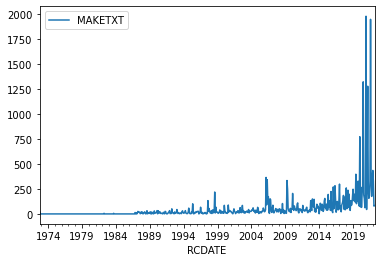

In [4]:
# let's recall what it looks like.
_ = y.plot()

<div class="span5 alert alert-warning">
<span style="color:black">

In our plot, we can see that both the mean and the variance increase as time progresses. At the moment, 
our data has neither a constant mean, nor a constant variance.<span>
</div>

In [5]:
# perform Augmented Dickey-Fuller test
adfuller(y)

(-1.103859480738362,
 0.7135303371716781,
 16,
 577,
 {'1%': -3.441734108219804,
  '5%': -2.8665621113012514,
  '10%': -2.5694446417404313},
 6984.019978927869)

<div class="span5 alert alert-warning">
<span style="color:black">

In statistical hypothesis testing,    the p-value or probability value is the probability of obtaining test results at least as extreme as the results actually observed during the test, assuming that the null hypothesis is correct.

<h5> if Test Statistic > Critical Values => Rejects the null hypothesis.</h5>
    
<h5> if Test Statistic < Critical Values => Failed to reject the null hypothesis.</h5>

<ul>
    
<li> test statistic: -1.103859480738362 </li>

<li> p-value: 0.7135303371716781 </li>

<li> Number of lags used in regression to determine t-statistic: 16 </li>

<li>  Number of observations used in the analysis: 577 </li>

<li> Critical values for the test statistic at the 1 %, 5 %, and 10 % </li>
    levels:   
    
  1%: -3.441734108219804,

  5%: -2.8665621113012514,
  
  10%: -2.5694446417404313
  
 </ul>
  <span></div>

 <div class="span5 alert alert-warning">
<span style="color:black">
(KPSS) test figures out if a time series is stationary around a mean or linear trend, or is non-stationary due to a unit root. A stationary time series is one where statistical properties — like the mean and variance — are constant over time.<span></div>

In [6]:
adf = adfuller(y)[1]
kpss_ = kpss(y, nlags="auto")[1]
print(f"Dickey-Fuller test p-value is {round(adf,3)}")
print(f"KPSS test p-value is {round(kpss_, 3)}")

Dickey-Fuller test p-value is 0.714
KPSS test p-value is 0.01


C:\Users\kurt_\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


<div class="span5 alert alert-warning">
<span style="color:black">

<h2>For Dickey-Fuller Test (ADF) test:</h2>

Null hypothesis: Non Stationarity exists in the series.
Alternative Hypothesis: Stationarity exists in the series

Since for p-value is much larger than 0.05, we can not reject the null hypothesis. 

<h2>For KPSS test:</h2>

Null hypothesis: the series is stationary

Since 
for ADF test p_value >> 0.05,
for KPSS test p_value < 0.05

Thus both of the test suggest that the series is non-stationary. The easist way to get rid of the trend and make the data stationary is to take the lagged difference of the values. In most of the cases this will take care of non-stationarity. Let's try a differencing for a few lag.<span></div>

In [7]:
import warnings
warnings.filterwarnings('ignore')
for i in range(3):
    if i == 0:
        y_diff = y
    elif i > 0:
        y_diff = y.diff(periods=i).dropna() 
        
    print(f'p-value of randomness \
    for period={i} = {adfuller(y_diff)[1]}')
    
    print(f'p-value of stationarity \
    for period={i} = {kpss(y_diff, nlags="auto")[1]}')
warnings.filterwarnings('default')

p-value of randomness     for period=0 = 0.7135303371716781
p-value of stationarity     for period=0 = 0.01
p-value of randomness     for period=1 = 2.0187222817646977e-09
p-value of stationarity     for period=1 = 0.1
p-value of randomness     for period=2 = 4.076522331164108e-09
p-value of stationarity     for period=2 = 0.1


<div class="span5 alert alert-warning">
<span style="color:black">

Based on these results first differencing is sufficient for making the data stationary.

Let's plot the data after differencing.<span></div>

C:\Users\kurt_\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


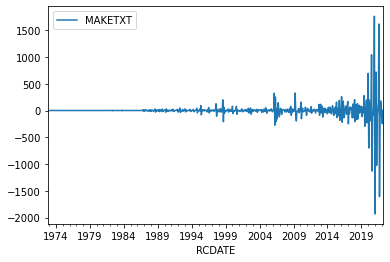

In [8]:
y_diff = y.diff().dropna()
_ = y_diff.plot()

<div class="span5 alert alert-warning">
<span style="color:black">Eventhough both the KPSS and ADF tests suggest that the data is stationary after the first differencing, we can see that from the above plot that the variance is increasing after 2000s and 2021 is still a strong outlier. The taking the logarithm can help with the increasing variance after 2000s but it will likely not help for the 2021 values.
    
<ul>
<li>Log transform is applied to make the data as normal as possible so that the statistical analysis results from this data become more valid. In other words, the log transformation reduces or removes the skewness of our original data.</li> </ul>
    <span></div>

C:\Users\kurt_\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dickey-Fuller test p-value is 0.0
KPSS test p-value is 0.1


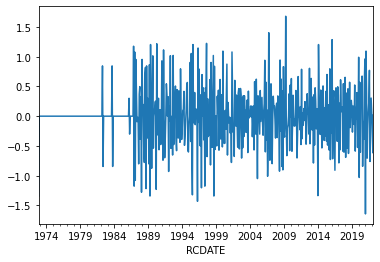

In [9]:
ylog = np.log10(y+1)
ylog_diff = ylog.diff().dropna()

inf = np.inf
ylog_diff = pd.DataFrame(ylog_diff).query('abs(MAKETXT) != inf')['MAKETXT'] # I did this to not include 
# infinite values. But since I already did np.log10(y+1) and got rid off infinite values, I do not 
# need it anymore.

warnings.filterwarnings('ignore')
adf = adfuller(ylog_diff )[1]
kpss_ = kpss(ylog_diff, nlags="auto")[1]
print(f"Dickey-Fuller test p-value is {round(adf,3)}")
print(f"KPSS test p-value is {round(kpss_, 3)}")
warnings.filterwarnings('default')

_ = ylog_diff.plot()

<div class="span5 alert alert-warning">
<span style="color:black">

This is clearly much better. Now the data both look stationary and pass the KPSS and ADF tests.<span></div>

C:\Users\kurt_\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


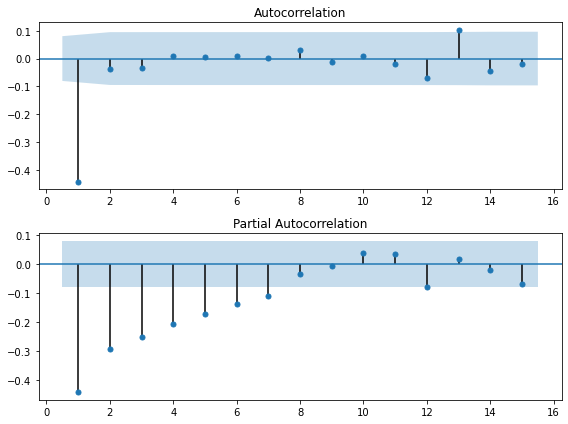

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6))

# plot ACF and PACF
plot_acf(ylog_diff, lags=15, zero=False, ax=ax1)
plot_pacf(ylog_diff, lags=15, zero=False, ax=ax2, method='ywm')

# show plot
plt.tight_layout()
plt.show()

<div class="span5 alert alert-warning">
<span style="color:black">

<ul>
<li>The auto correlation plot cuts off after the first lag 1.</li>
<li>PACF tails off.</li> </ul>

An ARIMA model with the order (0,1,1) might fit for the time series. Recall the model choosing criteria based on ACF and PACF plots:
    

<table><tbody><tr><th></th><th>AR(p)</th><th>MA(q)</th><th>ARMA(p,q)</th></tr><tr><td>ACF</td><td>Tails off</td><td>Cuts off after lag q</td><td>Tails off</td></tr><tr><td>PACF</td><td>Cuts off after lag p</td><td>Tails off</td><td>Tails off</td></tr></tbody></table>  <span></div>

<div class="span5 alert alert-warning">
<span style="color:black">

<h3> Model Selection</h3>
Three criteria will be used for model selection.
    
<ol>
<li>MSE error based on timestep-wise comparison between test data and one-step prediction ARIMA model</li>
    
<li> Akaike information criteria</li>
    
<li>Bayesian information criteria</li> </ol>
<span></div>

In [17]:
# import mean_squared_error and ARIMA
# make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    
    # needs to be an integer because it is later used as an index
    # use int()
    split = int(len(data) * 0.8) 
    
    # make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    
    # make predictions
    predictions = list()
    for i in range(len(test)): #timestep-wise comparison between test data and one-step prediction ARIMA model 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
        
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    
    # return the error
    return error

C:\Users\kurt_\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# function to evaluate different ARIMA models with several different p, d, and q values
def evaluate_models(dataset, p_values, d_values, q_values):
    score_dict = {'order':[], 'mse':[]}
    best_score, best_cfg = float("inf"), None
    
    # iterate through p_values
    for p in p_values:
        
        # iterate through d_values
        for d in d_values:
            
            # iterate through q_values
            for q in q_values:
                
                # p, d, q iterator variables in that order
                order = (p, d, q)
                
                try:
                    # make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    score_dict['order'].append(order)
                    score_dict['mse'].append(mse)
                    
                    print(f'ARIMA{order} MSE={round(mse, 4)}')
                    
                except:
                    continue
                    
    return pd.DataFrame(score_dict), print('Best ARIMA%s MSE=%.4f' % (best_cfg, best_score))

In [19]:
# now, we choose a couple of values to try for each parameter
# let's try up to 3 for each parameter
p_values = [i for i in range(3)] 
d_values = [i for i in range(3)] # p-val of kpss lower but still close to 0.05. Let's try up to d=2
q_values = [i for i in range(3)] 

In [21]:
# finally, we can find the optimum ARIMA model for our data.
import warnings
warnings.filterwarnings("ignore")
scores = evaluate_models(ylog_diff, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.2754
ARIMA(0, 0, 1) MSE=0.1405
ARIMA(0, 0, 2) MSE=0.1421
ARIMA(0, 1, 0) MSE=0.8135
ARIMA(0, 1, 1) MSE=0.2754
ARIMA(0, 1, 2) MSE=0.1409
ARIMA(0, 2, 0) MSE=2.6624
ARIMA(0, 2, 1) MSE=0.815
ARIMA(0, 2, 2) MSE=0.285
ARIMA(1, 0, 0) MSE=0.2141
ARIMA(1, 0, 1) MSE=0.1422
ARIMA(1, 0, 2) MSE=0.1421
ARIMA(1, 1, 0) MSE=0.4842
ARIMA(1, 1, 1) MSE=0.2141
ARIMA(1, 1, 2) MSE=0.1425
ARIMA(1, 2, 0) MSE=1.2794
ARIMA(1, 2, 1) MSE=0.4851
ARIMA(1, 2, 2) MSE=0.216
ARIMA(2, 0, 0) MSE=0.1844
ARIMA(2, 0, 1) MSE=0.1428
ARIMA(2, 0, 2) MSE=0.1431
ARIMA(2, 1, 0) MSE=0.3529
ARIMA(2, 1, 1) MSE=0.1844
ARIMA(2, 2, 0) MSE=0.8067
ARIMA(2, 2, 1) MSE=0.3537
ARIMA(2, 2, 2) MSE=0.186
Best ARIMA(0, 0, 1) MSE=0.1405


<div class="span5 alert alert-warning">
<span style="color:black">
Model with ARIMA(0, 1, 2) and ARIMA(0, 0, 1) have similar scores. We may choose a simplier model. Let's also check AIC, BIC scores to select the best order of ARIMA model.<span></div>

<div class="span5 alert alert-warning">
<span style="color:black">

<ul>
<li>The Akaike information criterion (AIC) is a mathematical method for evaluating how well a model fits the data it was generated from. In statistics, AIC is used to compare different possible models and determine which one is the best fit for the data. AIC is a single number score that can be used to determine which of multiple models is most likely to be the best model for a given dataset. It estimates models relatively, meaning that AIC scores are only useful in comparison with other AIC scores for the same dataset. A lower AIC score is better.</li>
    
<li>Bayesian information criterion (BIC) for model selection among a finite set of models; models with lower BIC are generally preferred. It is based, in part, on the likelihood function and it is closely related to the Akaike information criterion (AIC).</li> </ul>
<span></div>

In [22]:
# create empty list to store search results
order_aic_bic=[]
warnings.filterwarnings('ignore')
# loop over p values from 0-2
for p in range(3):
  # Loop over d values from 0-2
    for d in range(3):    
    # loop over q values from 0-2
        for q in range(3):
            # create and fit ARIMA(p,d,q) model
            try:
                model = ARIMA(ylog, order=(p, d, q))
                results = model.fit()

                # append order and results tuple
                order_aic_bic.append((p, d, q, results.aic, results.bic))
            except:
                order = (p, d, q)
                print(f'error in ARIMA{order}')
                continue
warnings.filterwarnings('default')

In [23]:
# construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'd', 'q', 'AIC', 'BIC'])

# print order_df in order of increasing AIC
order_df.sort_values('AIC').reset_index(drop=True).head()

C:\Users\kurt_\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,p,d,q,AIC,BIC
0,0,1,1,486.684326,495.454715
1,0,1,2,487.434913,500.590496
2,1,1,1,487.564670,500.720253
3,2,1,1,487.974634,505.515412
4,1,1,2,489.153399,506.694177


In [32]:
# create empty list to store search results
order_aic_bic=[]
warnings.filterwarnings('ignore')
# loop over p values from 0-2
for p in range(3):
  # loop over d values from 0-2
    for d in range(3):    
    # Loop over q values from 0-2
        for q in range(3):
            # create and fit SARIMAX
            try:
                model = sm.tsa.statespace.SARIMAX(ylog, order=(0, 1, 1),
                                                 seasonal_order=(p,d,q,12))
                results = model.fit()

                # append order and results tuple
                order_aic_bic.append((p, d, q, results.aic, results.bic))
            except:
                order = (p, d, q)
                print(f'error in ARIMA{order}')
                continue
warnings.filterwarnings('default')

C:\Users\kurt_\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
# construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'd', 'q', 'AIC', 'BIC'])

# print order_df in order of increasing AIC
order_df.sort_values('AIC').reset_index(drop=True).head()

C:\Users\kurt_\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,p,d,q,AIC,BIC
0,1,0,0,484.387340,497.542923
1,0,0,1,484.428680,497.584263
2,0,0,2,486.356388,503.897165
3,2,0,2,486.376486,512.687652
4,2,0,0,486.385941,503.926719


In [39]:
# calling SARIMAX and fitting to original data
mod = sm.tsa.statespace.SARIMAX(ylog,
                                order=(0, 1, 1), seasonal_order=(1,0,0,12))

results = mod.fit()

# one-step ahead prediction
pred = results.get_prediction(start=pd.to_datetime('1972-10-31'), dynamic=False)
pred_mean = 10**(pred.predicted_mean) - 1

pred_ci = pred.conf_int()
pred_ci = 10**(pred_ci) - 1

# dynamic 
pred_dynamic = results.get_prediction(start=pd.to_datetime('1972-10-31'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

# get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=24)
pred_uc_mean = 10**(pred_uc.predicted_mean) - 1

# get confidence intervals of forecasts
pred_uc_ci = pred_uc.conf_int()
pred_uc_ci = 10**(pred_uc_ci) - 1

C:\Users\kurt_\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


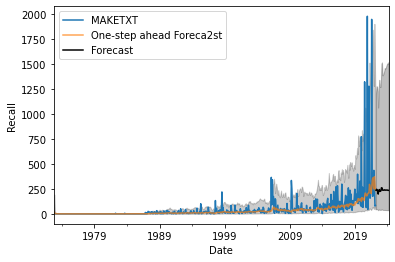

In [41]:
ax = y.plot(label='observed')
pred_mean.plot(ax=ax, label='One-step ahead Foreca2st', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
pred_uc_mean.plot(ax=ax, label='Forecast', c='k')
ax.fill_between(pred_uc_ci.index,
                pred_uc_ci.iloc[:, 0],
                pred_uc_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Recall')
plt.legend()

plt.show()

<div class="span5 alert alert-warning">
<span style="color:black">
    
<h2> CONCLUSION</h2>

The ARIMA model predicts that there will be a slight increase in recall campaings in the next month, then the mean value of recalls will be constant for the rest of the year. However, we should be cautious about this prediction because the last year (2021) was very unusual. Both the number of recalls were much higher than usual and the monthly variance was very large. Therefore the ARIMA model can not perform well with such an extreme outliers in the last year. 
    
<h2> Next Step</h2>
    
I did ARIMA forecasting for the total recalls of all the manufacturers. In the next step, we can do the same forecasting for individual manufacturers. To do that, I would rewrite this entire notebook as python class and functions in it. In a way that, one can repeat all these analysis for each manufcturer by only calling the methods of that class.
    
<span></div>